# **Local Outlier Factor (LOF)**

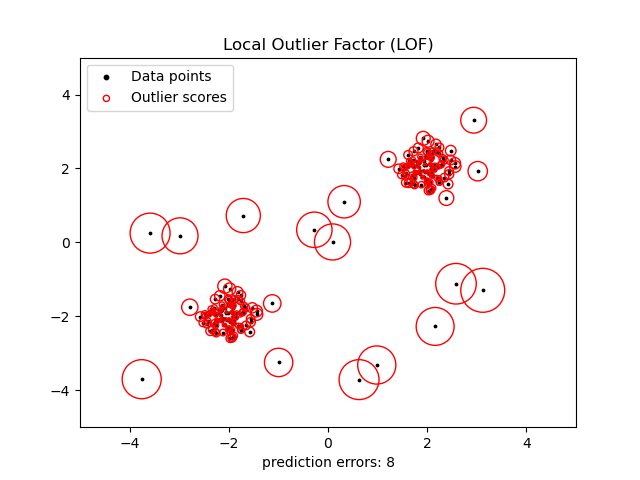

En este notebook , se tiene como objetivo mostrar el uso del modelo Local Outlier Factor (LOF) para la detección de anomalías en un conjunto de datos y mostrar su API de uso. El modelo LOF es un algoritmo de detección de anomalías basado en la densidad local de los puntos de datos. Se utiliza para identificar puntos que tienen una densidad significativamente menor que sus vecinos, lo que sugiere que son anomalías o outliers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys, os
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

## Dataset
información sobre el dataset 

In [2]:
url_data='https://drive.google.com/uc?export=download&id=1jGJ-Bam7dR9vH4Y6-677LNNpW-PulLfL'
data=pd.read_csv(url_data,header=0)
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
data['fraud']=data['fraud'].astype(np.int8)
data['fraud'].value_counts()

fraud
0    912597
1     87403
Name: count, dtype: int64

In [5]:
X_f=data.drop(['fraud'],axis=1)
y_f=data['fraud']
X,_,y,_= train_test_split(X_f,y_f,stratify=y_f,train_size=500,random_state=42)

In [6]:
y.value_counts()

fraud
0    456
1     44
Name: count, dtype: int64

In [7]:
X=StandardScaler().fit_transform(X)

In [8]:
X.mean(axis=0)

array([ 1.42108547e-17, -7.10542736e-18,  7.99360578e-17, -6.75015599e-17,
       -3.55271368e-18, -1.59872116e-17, -1.68753900e-16])

Ahora se va a ejecutar nuestra implementacion de LOF, en este caso para comparar los datos de LOF sin paralelizar y paralelizado, ambas son implementaciones propias basadas de los 

In [9]:
from PyOD_ADGE.models.lof import LOF
model= LOF('classic',n_neighbors=10,contamination=0.1)
model.fit(X)

In [11]:
scores = model.outlier_scores_
scores[:10]

array([1.2151488 , 0.96752158, 1.15084688, 1.07772207, 1.72732094,
       1.07099882, 0.99516575, 1.00508258, 1.0140994 , 1.44845638])

In [ ]:
model2 = LOF('optimized',n_neighbors=10,contamination=0.1)
model2.fit(X)

In [13]:
scores2 = model2.outlier_scores_
scores2[:10]

array([1.2151488 , 0.96752158, 1.15084688, 1.07772207, 1.72732094,
       1.07099882, 0.99516575, 1.00508258, 1.0140994 , 1.44845638])

- -1: indica que el punto es un outlier.
- 1: indica que el punto es un inlier.

In [12]:
ypred=model.decision_function()
ypred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
ypred2=model2.predict()
ypred2[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
Y_pred = model2.decision_function()
Y_pred[:10]

array([1.36237953, 1.44165918, 1.14056781, 1.05584919, 0.99308531,
       1.12846739, 1.0343905 , 1.0599803 , 1.12760894, 1.07270544])

In [15]:
(ypred==ypred2).sum()

np.int64(3000)

In [16]:
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.1645074 0.149128 ]


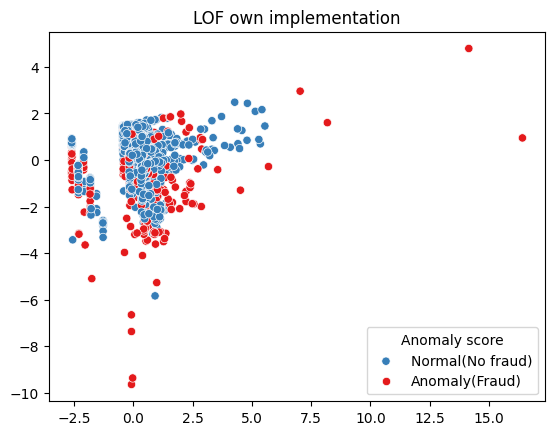

In [17]:
fig,ax=plt.subplots()
sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],hue=ypred,ax=ax,palette="Set1")
plt.title('LOF own implementation')
ax.legend(title='Anomaly score',loc='lower right',labels=['Normal(No fraud)','Anomaly(Fraud)'])
plt.show()

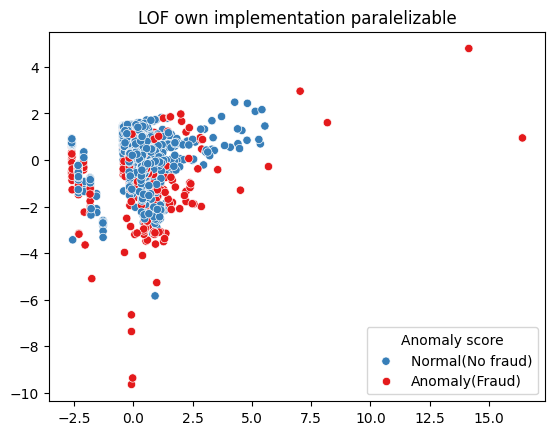

In [18]:
fig,ax=plt.subplots()
sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],hue=ypred2,ax=ax,palette="Set1")
plt.title('LOF own implementation paralelizable')
ax.legend(title='Anomaly score',loc='lower right',labels=['Normal(No fraud)','Anomaly(Fraud)'])
plt.show()

In [19]:
import time
from joblib import Parallel,delayed
import math

t1 = time.time()

# 2 Core
r1 = Parallel(n_jobs=2)(delayed(math.factorial) (int(math.sqrt(i**3))) for i in range(100,1000))
r1

t2 = time.time()

print(t2-t1)

5.491088628768921


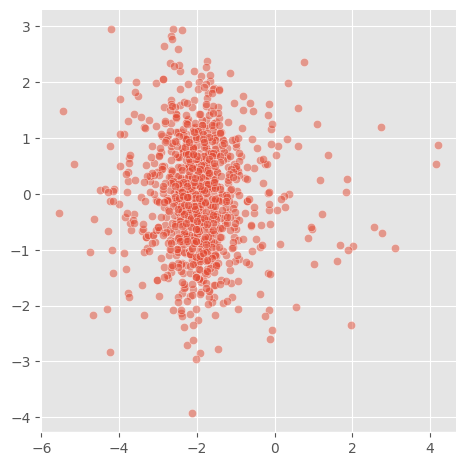

In [20]:
from sklearn.datasets import make_classification
X2, y2 = make_classification(n_samples=1000, n_features=10,
                           n_informative=2, n_redundant=0,
                           weights=[0.98], flip_y=0,
                           class_sep=2, random_state=42)

plt.style.use('ggplot')
sns.relplot(x=X2[:,0],y=X2[:,1],alpha=0.5)
plt.show()

In [21]:
model3 = LocalOutlierFactorParalelizable(k_neighbors=20, n_jobs=8)
model3.fit(X2)
# f,s=model.get()

LocalOutlierFactorParalelizable(n_jobs=8)

In [23]:
ypred3=model3.predict()
ypred3[:10]

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1])

In [24]:
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X2)
print(pca.explained_variance_ratio_)

[0.32446203 0.08886621]


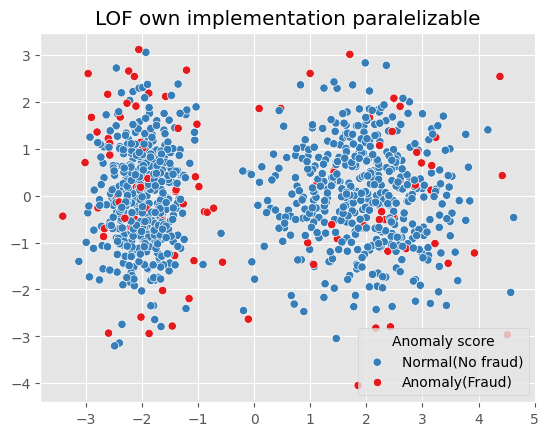

In [25]:
fig,ax=plt.subplots()
sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],hue=ypred3,ax=ax,palette="Set1")
plt.title('LOF own implementation paralelizable')
ax.legend(title='Anomaly score',loc='lower right',labels=['Normal(No fraud)','Anomaly(Fraud)'])
plt.show()